In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# df = pd.read_excel("../data/Coffee Shop Sales.xlsx", engine='openpyxl')
# df.to_csv('../data/Coffee Shop Sales.csv', index=False)
df = pd.read_csv("../data/Coffee Shop Sales.csv")
df.head()

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail
0,1,2023-01-01,07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg
1,2,2023-01-01,07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg
2,3,2023-01-01,07:14:04,2,5,Lower Manhattan,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg
3,4,2023-01-01,07:20:24,1,5,Lower Manhattan,22,2.0,Coffee,Drip coffee,Our Old Time Diner Blend Sm
4,5,2023-01-01,07:22:41,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg


In [3]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149116 entries, 0 to 149115
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   transaction_id    149116 non-null  int64  
 1   transaction_date  149116 non-null  object 
 2   transaction_time  149116 non-null  object 
 3   transaction_qty   149116 non-null  int64  
 4   store_id          149116 non-null  int64  
 5   store_location    149116 non-null  object 
 6   product_id        149116 non-null  int64  
 7   unit_price        149116 non-null  float64
 8   product_category  149116 non-null  object 
 9   product_type      149116 non-null  object 
 10  product_detail    149116 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 12.5+ MB


transaction_id      0
transaction_date    0
transaction_time    0
transaction_qty     0
store_id            0
store_location      0
product_id          0
unit_price          0
product_category    0
product_type        0
product_detail      0
dtype: int64

In [4]:
# Create a new column for total trasaction value (sales)
df["sales"] = df["transaction_qty"] * df["unit_price"]

# I convert the time column to string first to ensure consistency, then calculate hour
df["transaction_hour"] = (
    df["transaction_time"].astype(str).str.split(":").str[0].astype(int)
)

df[
    ["transaction_time", "transaction_hour", "transaction_qty", "unit_price", "sales"]
].head()

,transaction_time,transaction_hour,transaction_qty,unit_price,sales
0,07:06:11,7,2,3.0,6.0
1,07:08:56,7,2,3.1,6.2
2,07:14:04,7,2,4.5,9.0
3,07:20:24,7,1,2.0,2.0
4,07:22:41,7,2,3.1,6.2


In [5]:
# Get summary statistics for numerical columns
# This helps identify outliers (e.g., negative quantity or extreme prices)
df.describe()

,transaction_id,transaction_qty,store_id,product_id,unit_price,sales,transaction_hour
count,149116.000000,149116.000000,149116.000000,149116.000000,149116.000000,149116.000000,149116.000000
mean,74737.371872,1.438276,5.342063,47.918607,3.382219,4.686367,11.735790
std,43153.600016,0.542509,2.074241,17.930020,2.658723,4.227099,3.764662
min,1.000000,1.000000,3.000000,1.000000,0.800000,0.800000,6.000000
25%,37335.750000,1.000000,3.000000,33.000000,2.500000,3.000000,9.000000
50%,74727.500000,1.000000,5.000000,47.000000,3.000000,3.750000,11.000000
75%,112094.250000,2.000000,8.000000,60.000000,3.750000,6.000000,15.000000
max,149456.000000,8.000000,8.000000,87.000000,45.000000,360.000000,20.000000


In [6]:
# how many transactions included multiple items
transaction_counts = df["transaction_id"].value_counts()

# oders with more than 1 item
multi_item_txns = transaction_counts[transaction_counts > 1]

print(f"there are {len(multi_item_txns)} orders that included more than 1 item.")

there are 0 orders that included more than 1 item.


### 1. What time of the day has the highest sales?
Analyze hourly sales trends to identify peak shopping hours.

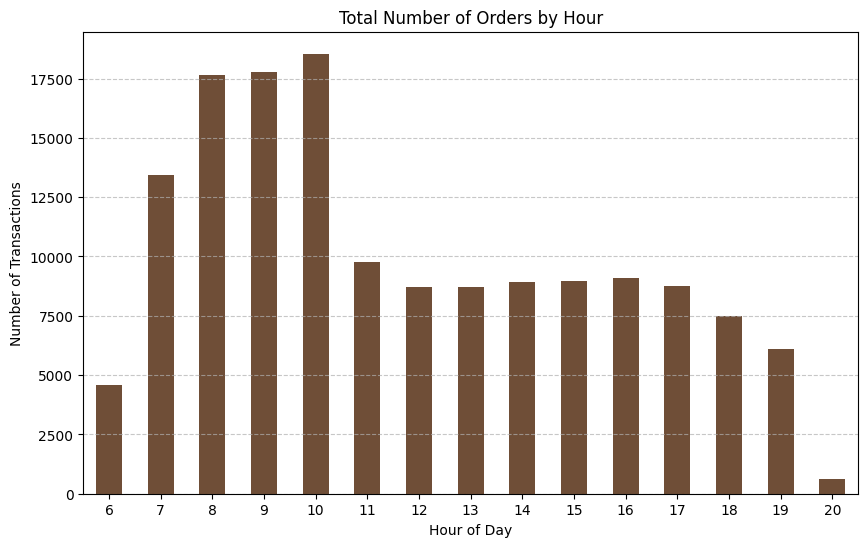

Busiest Hours (Order Counts):
transaction_hour
10    18545
9     17764
8     17654
Name: transaction_id, dtype: int64


In [7]:
# group by hour and count transaction
hourly_counts = df.groupby("transaction_hour")["transaction_id"].count()

# plot bar chart
plt.figure(figsize=(10, 6))
hourly_counts.plot(kind="bar", color="#6f4e37")  # use coffee color

plt.title("Total Number of Orders by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

# print out top 3 hours
print("Busiest Hours (Order Counts):")
print(hourly_counts.sort_values(ascending=False).head(3))

In [8]:
# 1. Calculate the number of unique days
num_days = df["transaction_date"].nunique()

# 2. Divide your existing hourly_counts by num_days to get the daily average
avg_hourly_counts = hourly_counts / num_days

# 3. Sort and print the top 3
top_3_hours = avg_hourly_counts.sort_values(ascending=False).head(3)

print("Top 3 Hours by Average Daily Transaction Volume:")
print(top_3_hours)

Top 3 Hours by Average Daily Transaction Volume:
transaction_hour
10    102.458564
9      98.143646
8      97.535912
Name: transaction_id, dtype: float64


Peak Trading Hours Anlayisis

Observation：
As illustrated in the bar chart, sales volume is heavily concentrated in the morning hours. The peak trading period occurs between 8:00AM and 10:00AM, with the highest volume at 10:00AM (average about 102 transactions).



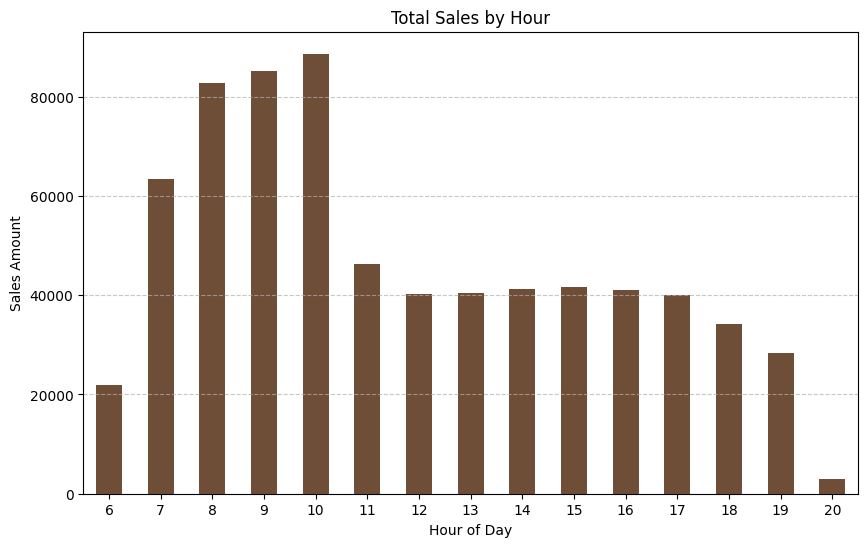

Highest Revenue Hours:
transaction_hour
10    88673.39
9     85169.53
8     82699.87
Name: sales, dtype: float64


In [9]:
# group by hour and count transaction
hourly_sales = df.groupby("transaction_hour")["sales"].sum()

# plot bar chart
plt.figure(figsize=(10, 6))
hourly_sales.plot(kind="bar", color="#6f4e37")  # use coffee color

plt.title("Total Sales by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Sales Amount")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

# print out top 3 hours
print("Highest Revenue Hours:")
print(hourly_sales.sort_values(ascending=False).head(3))

In [10]:
# Divide existing hourly_sales by num_days to get the daily average
avg_hourly_sales = hourly_sales / num_days

# 3. Sort and print the top 3
top_3_hours = avg_hourly_sales.sort_values(ascending=False).head(3)

print("Top 3 Hours by Average Daily Sales Amount:")
print(top_3_hours)

Top 3 Hours by Average Daily Sales Amount:
transaction_hour
10    489.908232
9     470.549890
8     456.905359
Name: sales, dtype: float64


### 2. Which stores or regions perform best in terms of sales?
Compare total revenue and order volume across locations.

In [11]:
# 1. Group by 'store_location' to compare performance
# Using 'transaction_id' count for Order Volume and 'sales' sum for Revenue
store_performance = df.groupby("store_location").agg(
    total_sales=("sales", "sum"),
    order_volume=("transaction_id", "nunique"),
    total_qty=("transaction_qty", "sum"),
)

# 2. Sort by total sales in descending order
store_performance = store_performance.sort_values(by="total_sales", ascending=False)

store_performance["average_order_value"] = (
    store_performance["total_sales"] / store_performance["order_volume"]
)
store_performance["unit_per_transaction"] = (
    store_performance["total_qty"] / store_performance["order_volume"]
)

print(store_performance)

                 total_sales  order_volume  total_qty  average_order_value  \
store_location                                                               
Hell's Kitchen     236511.17         50735      71737             4.661696   
Astoria            232243.91         50599      70991             4.589891   
Lower Manhattan    230057.25         47782      71742             4.814726   

                 unit_per_transaction  
store_location                         
Hell's Kitchen               1.413955  
Astoria                      1.403012  
Lower Manhattan              1.501444  


Store Performance Insight
1. Efficiency vs. Volume

Lower Manhattan is the most efficient location in terms of basket size. Despite having the lowest foot traffic (47,782 orders), it achieves the highest Units Per Transaction (UPT) of 1.50. This indicates a strong customer tendency to purchase multiple items per visit (e.g., pairing food with drinks).

Hell's Kitchen and Astoria are volume-driven locations. They rely on high transaction counts (>50,000 orders) to drive revenue, but their lower UPT (~1.40–1.41) suggests customers typically purchase single items.

2. Strategic Recommendations

For Lower Manhattan: The primary opportunity is Traffic Acquisition. Since existing customers already spend well (high UPT), marketing efforts should focus on increasing store visits to leverage this high conversion efficiency.

For Hell's Kitchen & Astoria: The primary opportunity is Cross-selling. Strategies such as bundling promotions (e.g., "Add a pastry for $2") could help lift their UPT from 1.41 to the 1.50 benchmark set by Lower Manhattan, significantly boosting total revenue without needing more customers.

3. Scale Effect

Hell's Kitchen (UPT 1.41) has 50,735 orders, and sold 71,737 items. But if Hell's Kitchen reached Lower Manhattan's level (UPT 1.50), it will sell 76,102 items. And those items are additional items, for example, scone ($3.50), if so, this store will lose 15,000+ revenue. We can dive deep into this to check what category of product generate this difference.

### 3. Which product categories and types generate the most revenue?
Identify top-performing categories by sales volume and value.

In [13]:
# 1. create pivot talbe: to check total quantity of each catergory by store location
category_pivot = df.pivot_table(
    index="product_category",
    columns="store_location",
    values="transaction_qty",
    aggfunc="sum",
)

# 2. calculate category percentage by store
# axis=0 means sum by column, div means division
category_mix = category_pivot.div(category_pivot.sum(axis=0), axis=1)

print("=== Total Quantity by Category ===")
print(category_pivot)
print("\n=== Percentage Mix by Store ===")
print(category_mix)

=== Total Quantity by Category ===
store_location      Astoria  Hell's Kitchen  Lower Manhattan
product_category                                            
Bakery                 7496            7678             8040
Branded                 279             119              378
Coffee                29655           30220            29375
Coffee beans            502             790              536
Drinking Chocolate     6351            5672             5434
Flavours               2206            3596             4709
Loose Tea               344             485              381
Packaged Chocolate      110             197              180
Tea                   24048           22980            22709

=== Percentage Mix by Store ===
store_location       Astoria  Hell's Kitchen  Lower Manhattan
product_category                                             
Bakery              0.105591        0.107030         0.112068
Branded             0.003930        0.001659         0.005269
Coffee       

Notice that Lower Manhattan has the highest percentage of Flavours and Bakery, these 2 categories are the reasons of its high UPT (1.5).

By looking at Astoria's data, it has the highest percentage of drinks (Coffee, Tea, Drinking Chocolate). Which makes it a drink shop.

In [ ]:
# 1. Group by Category and Type, then sum Sales
revenue_analysis = df.groupby(["product_category"])["sales"].sum().reset_index()

# 2. Sort by Sales in descending order
top_performers = revenue_analysis.sort_values(by="sales", ascending=False)

# 3. Calculate Cumulative Percentage
total_revenue = top_performers["sales"].sum()
top_performers["revenue_share"] = top_performers["sales"] / total_revenue

# 4. Display the top 10 results
# Format sales for better readability
display_df = top_performers.copy()
display_df["sales"] = display_df["sales"].apply(lambda x: "${:,.2f}".format(x))
display_df["revenue_share"] = display_df["revenue_share"].apply(
    lambda x: "{:.2%}".format(x)
)

print(display_df[["product_category", "sales", "revenue_share"]].head(5))

     product_category        sales revenue_share
2              Coffee  $269,952.45        38.63%
8                 Tea  $196,405.95        28.11%
0              Bakery   $82,315.64        11.78%
4  Drinking Chocolate   $72,416.00        10.36%
3        Coffee beans   $40,085.25         5.74%


Coffee is the dominant category, accounting for nearly 39% of total revenue, followed by tea at 28%. These tow together make up over 2/3 of total sales, indicating that beverages are the primary revenue drivers.

In [ ]:
# 1. Group by Category and Type, then sum Sales
revenue_analysis = (
    df.groupby(["product_category", "product_type"])["sales"].sum().reset_index()
)

# 2. Sort by Sales in descending order
top_performers = revenue_analysis.sort_values(by="sales", ascending=False)

# 3. Calculate Cumulative Percentage
total_revenue = top_performers["sales"].sum()
top_performers["revenue_share"] = top_performers["sales"] / total_revenue

# 4. Display the top 10 results
# Format sales for better readability
display_df = top_performers.copy()
display_df["sales"] = display_df["sales"].apply(lambda x: "${:,.2f}".format(x))
display_df["revenue_share"] = display_df["revenue_share"].apply(
    lambda x: "{:.2%}".format(x)
)

print(
    display_df[["product_category", "product_type", "sales", "revenue_share"]].head(10)
)

      product_category           product_type       sales revenue_share
5               Coffee       Barista Espresso  $91,406.20        13.08%
26                 Tea        Brewed Chai tea  $77,081.95        11.03%
16  Drinking Chocolate          Hot chocolate  $72,416.00        10.36%
7               Coffee  Gourmet brewed coffee  $70,034.60        10.02%
25                 Tea       Brewed Black tea  $47,932.00         6.86%
28                 Tea      Brewed herbal tea  $47,539.50         6.80%
9               Coffee  Premium brewed coffee  $38,781.15         5.55%
8               Coffee  Organic brewed coffee  $37,746.50         5.40%
2               Bakery                  Scone  $36,866.12         5.28%
6               Coffee            Drip coffee  $31,984.00         4.58%


In [ ]:
top_performers["revenue_share"].head(10).sum()

np.float64(0.7896083058523022)

Key Insights from Top 10 Products by Sales

Executive Summary:
The top 10 products account for ~79% of total revenue, with coffee, tea, hot chocolate, and bakery forming the core revenue pillars.

The top 4 items Barista Espresso, Brewed Chai tea, Hot chocolate, Gourmet brewed coffee contributed ~44.5% total revenue. We need to pay attention to these products about their quality and stock.

Scone is the only food that appeared on the ranking. If we want to rise the UPT, this could be the chance.
Action: bundling barista espresso and scone. 
        Place the scone on the most accessible place.



Noticed that hot cholocate is the third highest revenue-generating product type. Building on this insight, I will further inverstigate potential seasonality in hot chocolate sales.

In [ ]:
df["transaction_date"] = pd.to_datetime(df["transaction_date"])

target_product = "Hot chocolate"
product_df = df[df["product_type"] == target_product].copy()

product_df["Month"] = product_df["transaction_date"].dt.month
product_df["Month_Name"] = product_df["transaction_date"].dt.strftime(
    "%b"
)  # Jan, Feb...

# Seasonality
monthly_trend = (
    product_df.groupby(["Month", "Month_Name"])["transaction_qty"].sum().reset_index()
)

# above Average
avg_monthly_sales = monthly_trend["transaction_qty"].mean()
monthly_trend["vs_Average"] = monthly_trend["transaction_qty"] - avg_monthly_sales
monthly_trend["Status"] = monthly_trend["vs_Average"].apply(
    lambda x: "🔥 High Season" if x > 0 else "❄️ Low Season"
)

print(f"=== {target_product} Monthly Seasonality ===")
print(monthly_trend[["Month_Name", "transaction_qty", "Status"]])

=== Hot chocolate Monthly Seasonality ===
  Month_Name  transaction_qty         Status
0        Jan             2015  ❄️ Low Season
1        Feb             1964  ❄️ Low Season
2        Mar             2475  ❄️ Low Season
3        Apr             2952  🔥 High Season
4        May             3930  🔥 High Season
5        Jun             4121  🔥 High Season


Observation: Contrary to the traditional expectation of Hot Chocolate being a "Winter Warmer," the data reveals a counter-intuitive "Spring Surge." Sales do not drop off after February; instead, they accelerate significantly, nearly doubling from the February low (1,964 units) to a peak in June (4,121 units).

Actionable Takeaway: Do not de-stock chocolate inventory in March. Operations must prepare for peak consumption in Q2 (Apr–Jun). Marketing should shift messaging from "Warm Up" to "Treat Yourself" to align with this consumption behavior.